In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Thu Apr 15 15:28:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.1.5
torch      : 1.8.1+cu101
torchvision: 0.9.1+cu101



In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_folders = sorted(glob('/content/drive/MyDrive/70:30_Datasets/70:30_train_test/*'))
len(train_folders)

5

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

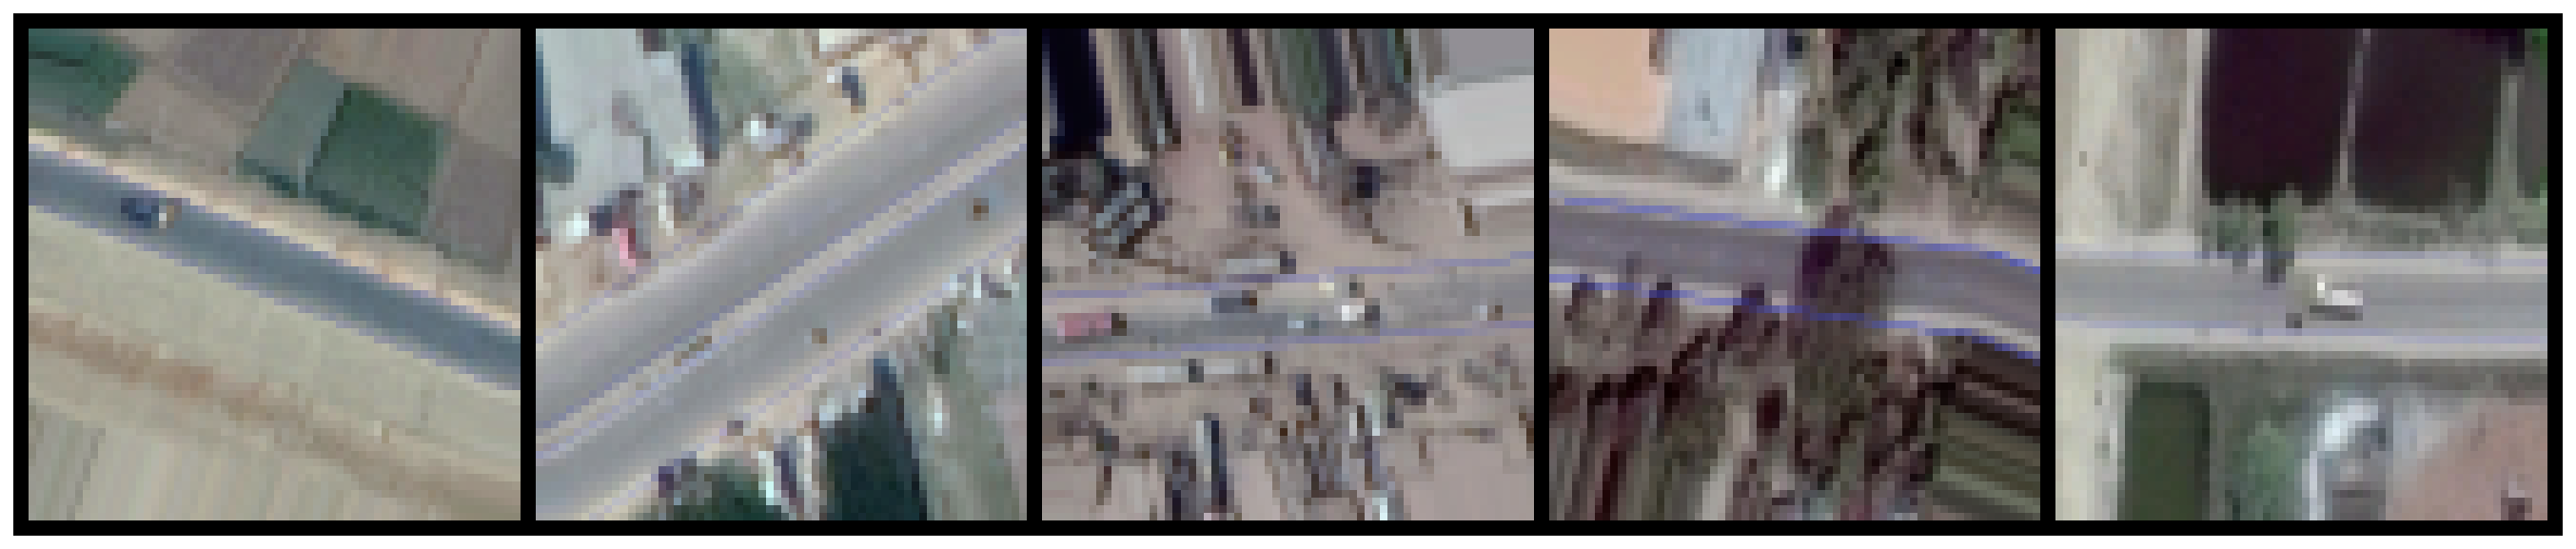

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in train_folders]
show_sign_grid(sample_images)

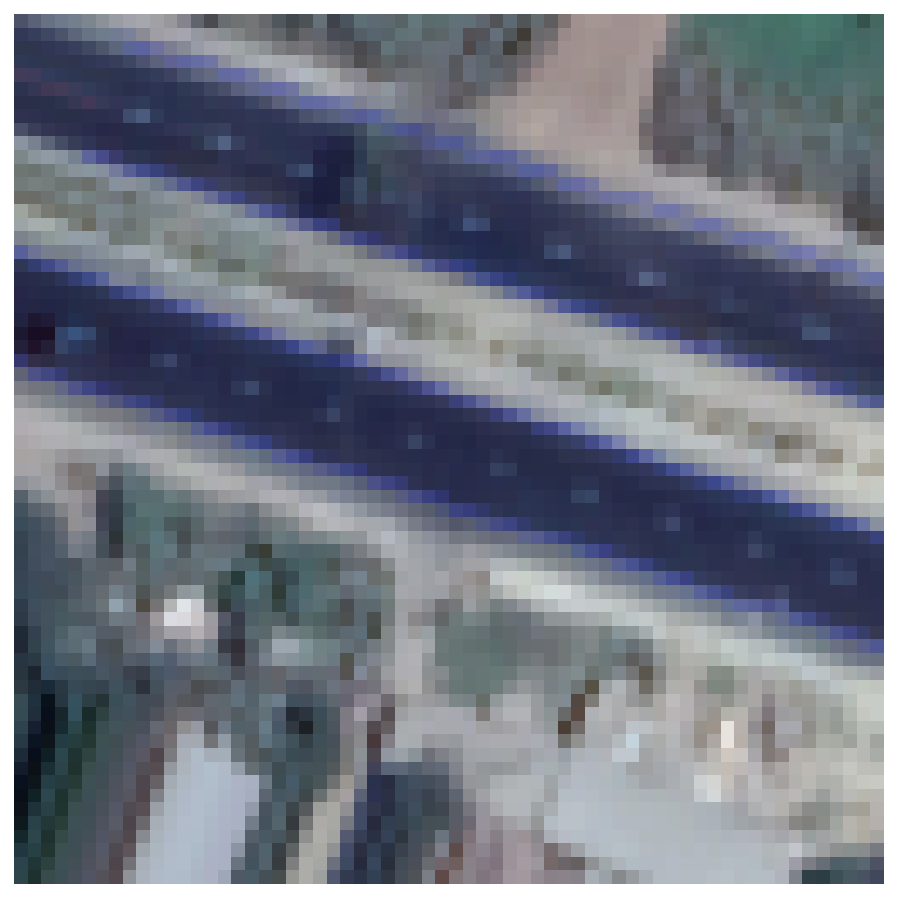

In [ ]:
img_path = glob(f'{train_folders[2]}/*png')[20]

show_image(img_path)

In [ ]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 4228
fair: 4779
good: 4812
poor: 4368
vbad: 3728


In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=16, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 17530, 'val': 4385}

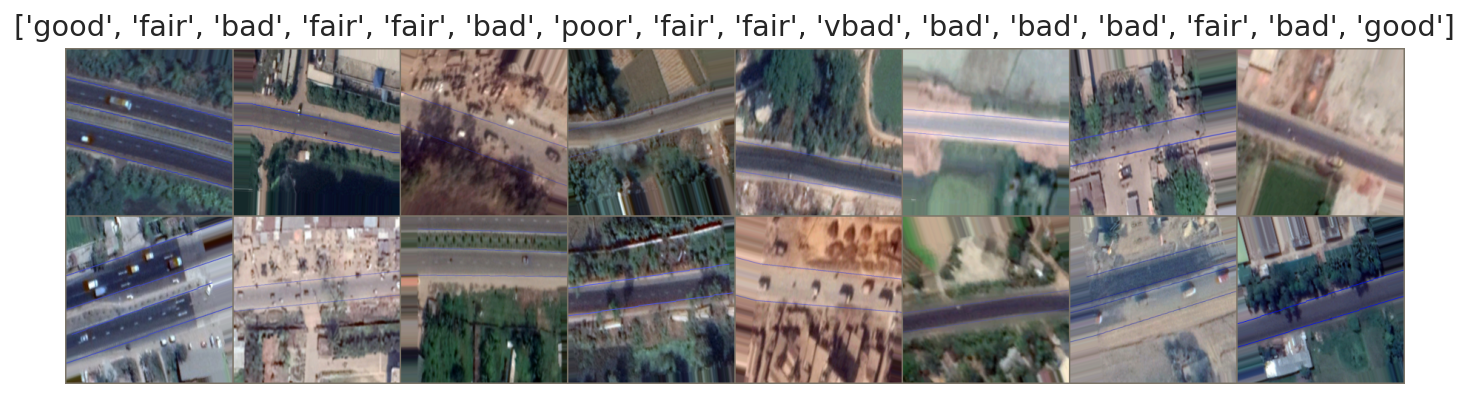

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def create_model(n_classes):
  base_model = models.densenet161(pretrained=True)
  base_model.classifier = nn.Linear(2208, n_classes) #where args.num_classes = 8142
  #model.fc = nn.Linear(2048, n_classes)

  return base_model.to(device)

In [ ]:
base_model = create_model(len(class_names))

In [ ]:
print(base_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=10):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [ ]:
%%time
#64*64
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.8773262445291463 accuracy 0.64968625213919
Val   loss 0.6313709836939106 accuracy 0.7594070695553021

Epoch 2/10
----------
Train loss 0.3432026733474357 accuracy 0.8767826583000571
Val   loss 0.44843586393242574 accuracy 0.8456100342075257

Epoch 3/10
----------
Train loss 0.1364861299950004 accuracy 0.9556189389617799
Val   loss 0.33769471155128616 accuracy 0.8903078677309008

Epoch 4/10
----------
Train loss 0.06485835661606891 accuracy 0.9808328579577867
Val   loss 0.3127589193847624 accuracy 0.8960091220068415

Epoch 5/10
----------
Train loss 0.04021093513889673 accuracy 0.9875641756988021
Val   loss 0.29218954447845835 accuracy 0.9076396807297605

Epoch 6/10
----------
Train loss 0.0272069731539236 accuracy 0.9924130062749573
Val   loss 0.3074223449102778 accuracy 0.9101482326111744

Epoch 7/10
----------
Train loss 0.022323503585718826 accuracy 0.9930975470621791
Val   loss 0.26823437324576616 accuracy 0.9181299885974914

Epoch 8/10
----------

In [ ]:
%%time
#224*224
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.6027539121292966 accuracy 0.7613804905875642
Val   loss 0.3173165897415443 accuracy 0.8770809578107184

Epoch 2/10
----------
Train loss 0.19507898719739986 accuracy 0.9306902452937821
Val   loss 0.19941268588506236 accuracy 0.9302166476624857

Epoch 3/10
----------
Train loss 0.07934488160278645 accuracy 0.973245864232744
Val   loss 0.10987835281613198 accuracy 0.9600912200684151

Epoch 4/10
----------
Train loss 0.04377937822270863 accuracy 0.9864232743867656
Val   loss 0.08281610957172234 accuracy 0.9708095781071836

Epoch 5/10
----------
Train loss 0.031120282320165126 accuracy 0.9903593839132916
Val   loss 0.16622183115566838 accuracy 0.9438996579247434

Epoch 6/10
----------
Train loss 0.02739835739514729 accuracy 0.9919566457501426
Val   loss 0.07352197688588852 accuracy 0.9758266818700114

Epoch 7/10
----------
Train loss 0.02026457492486299 accuracy 0.9938391329150029
Val   loss 0.06329290544159118 accuracy 0.9783352337514253

Epoch 8/10
----

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

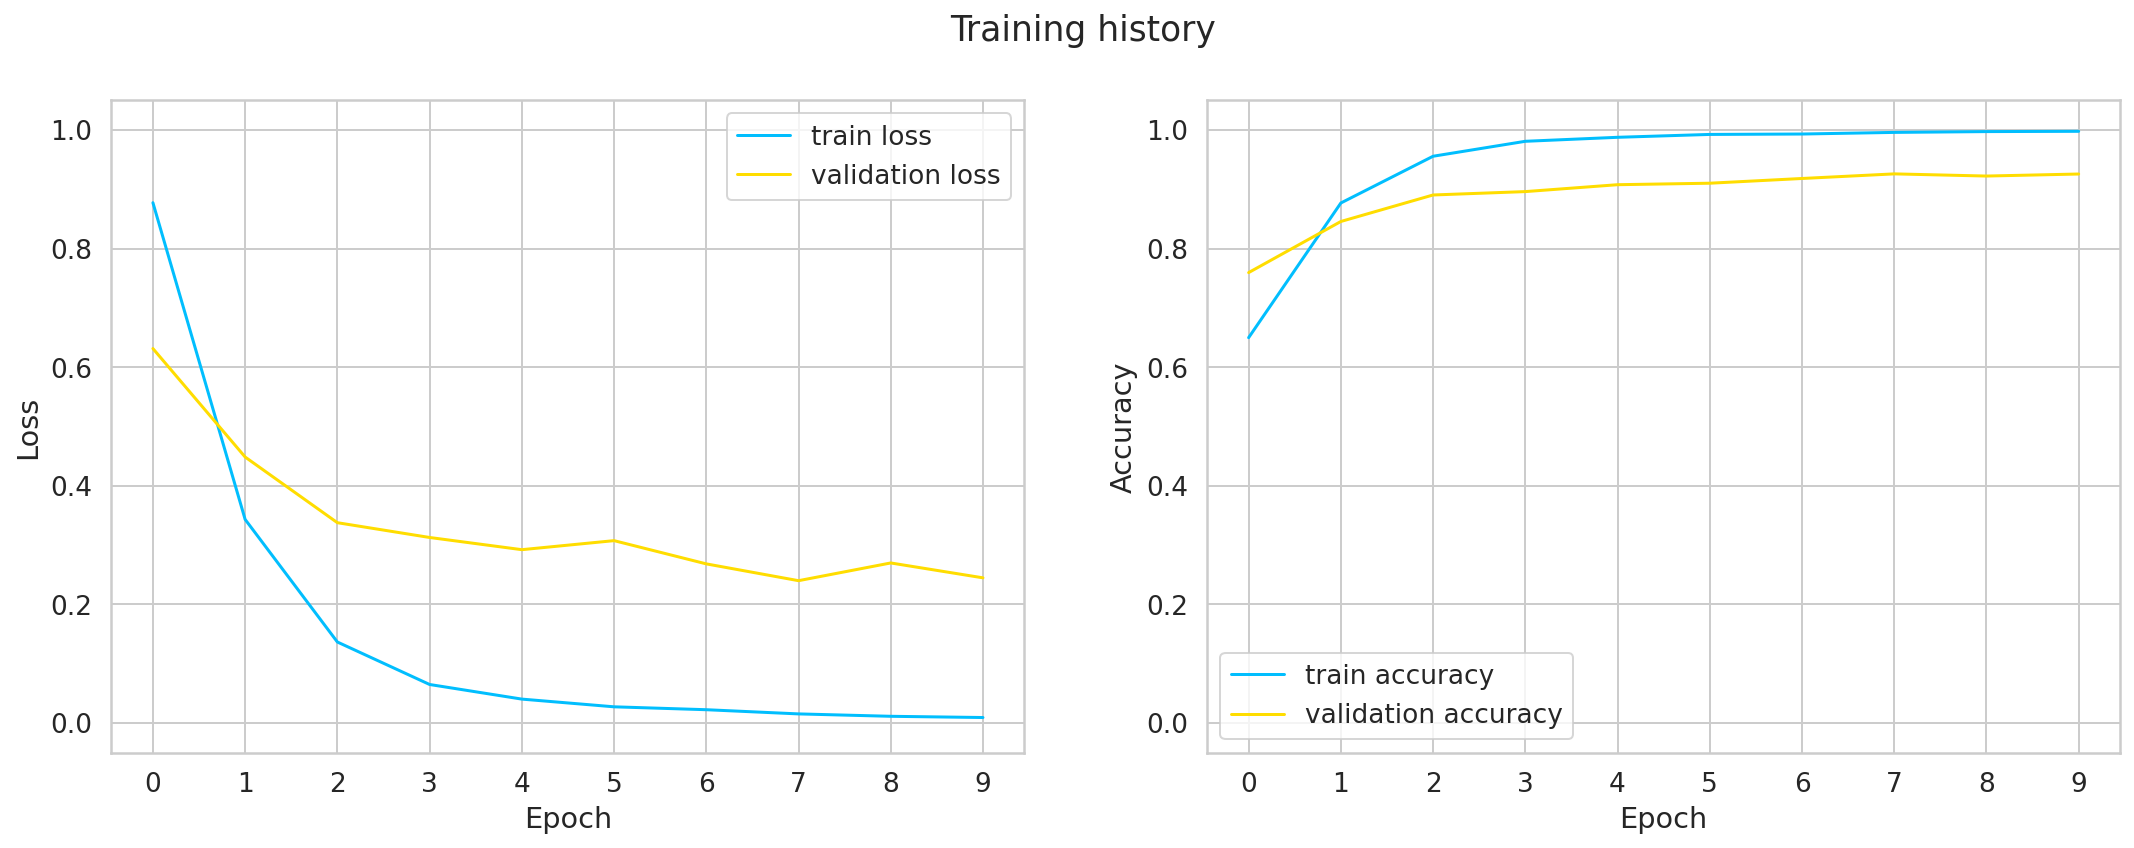

In [ ]:
#64*64
plot_training_history(history)

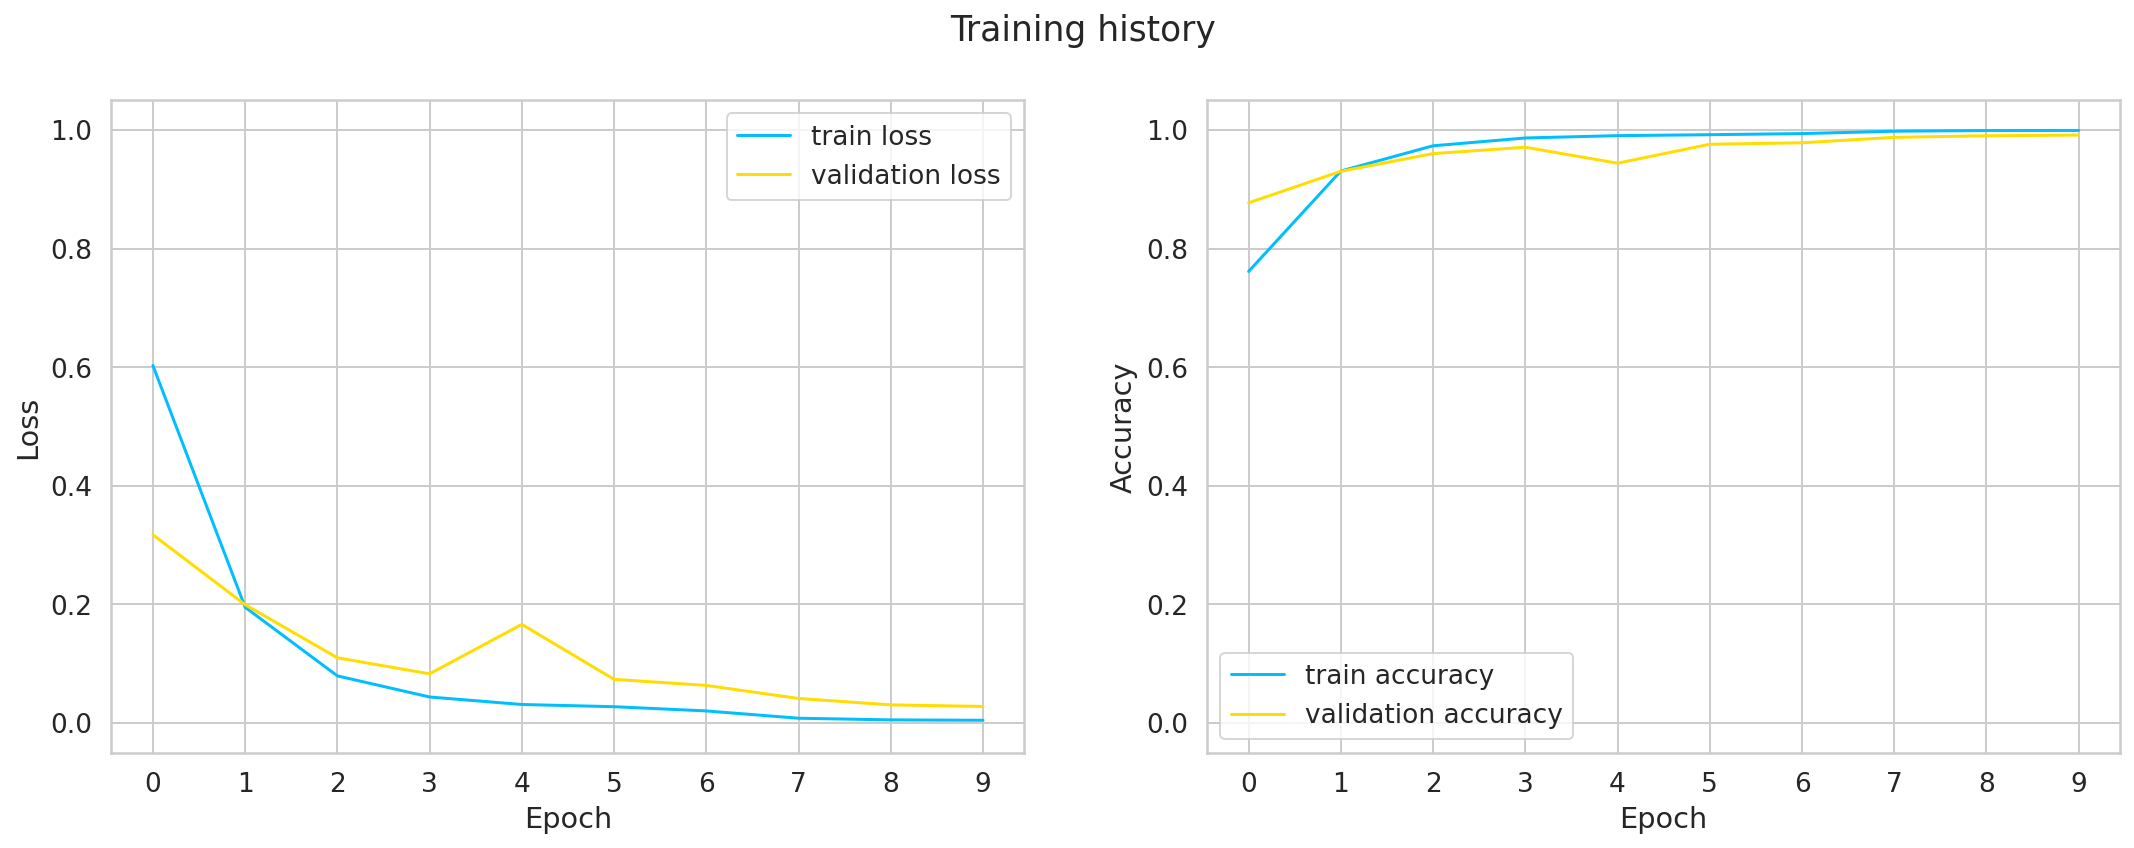

In [ ]:
#224*224
plot_training_history(history)

# **Test Data**(unseen)

In [ ]:
test_folders = sorted(glob('/content/drive/MyDrive/70:30_Datasets/test_set/*'))
len(test_folders)

5

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

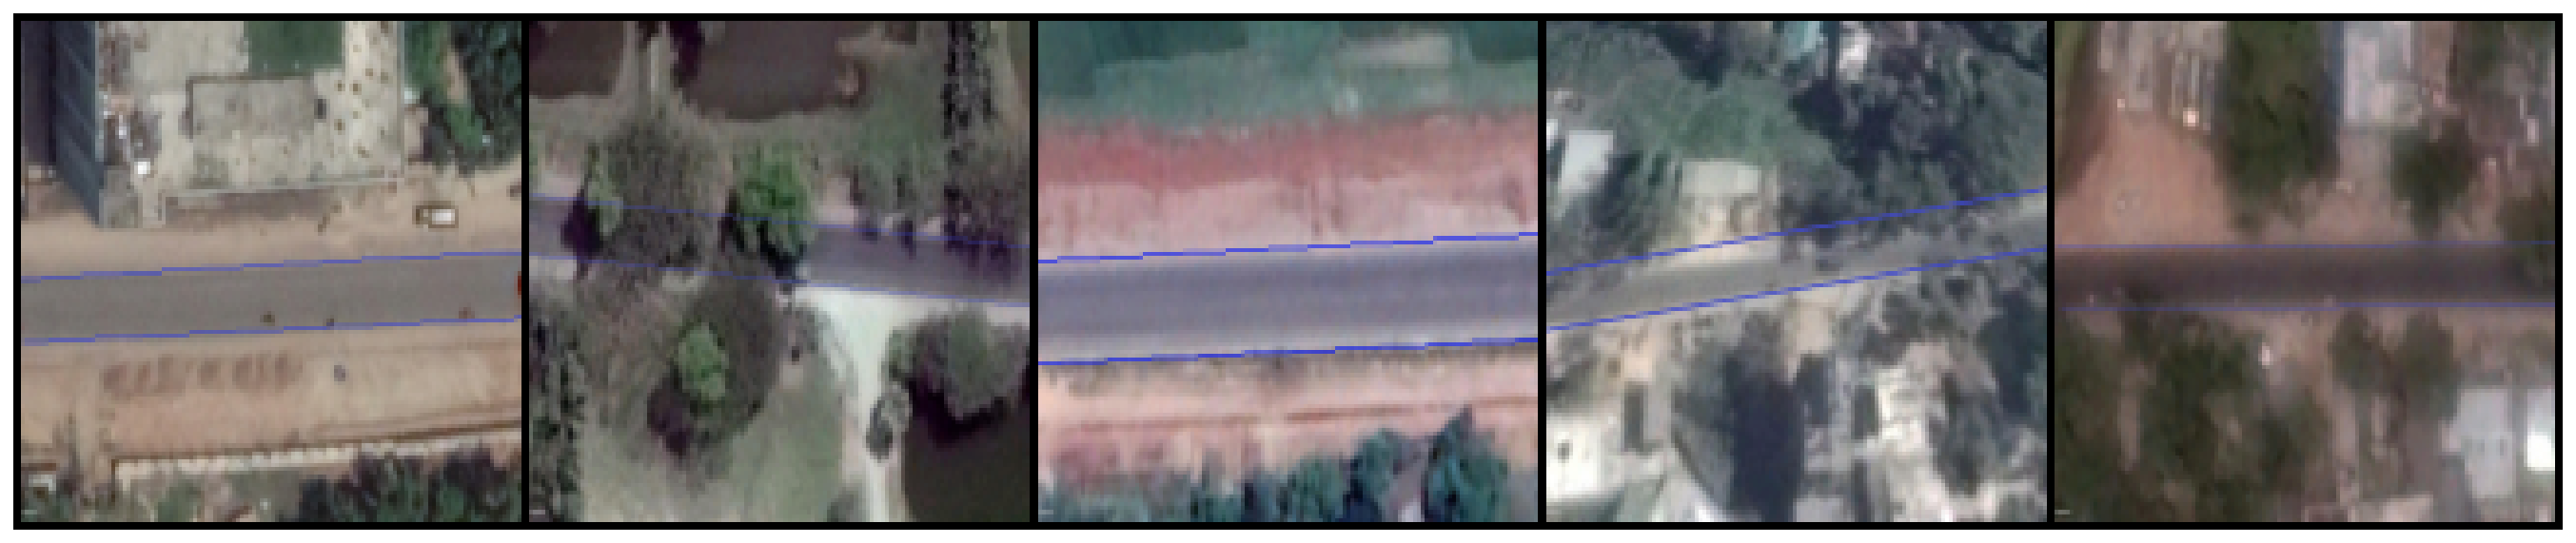

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

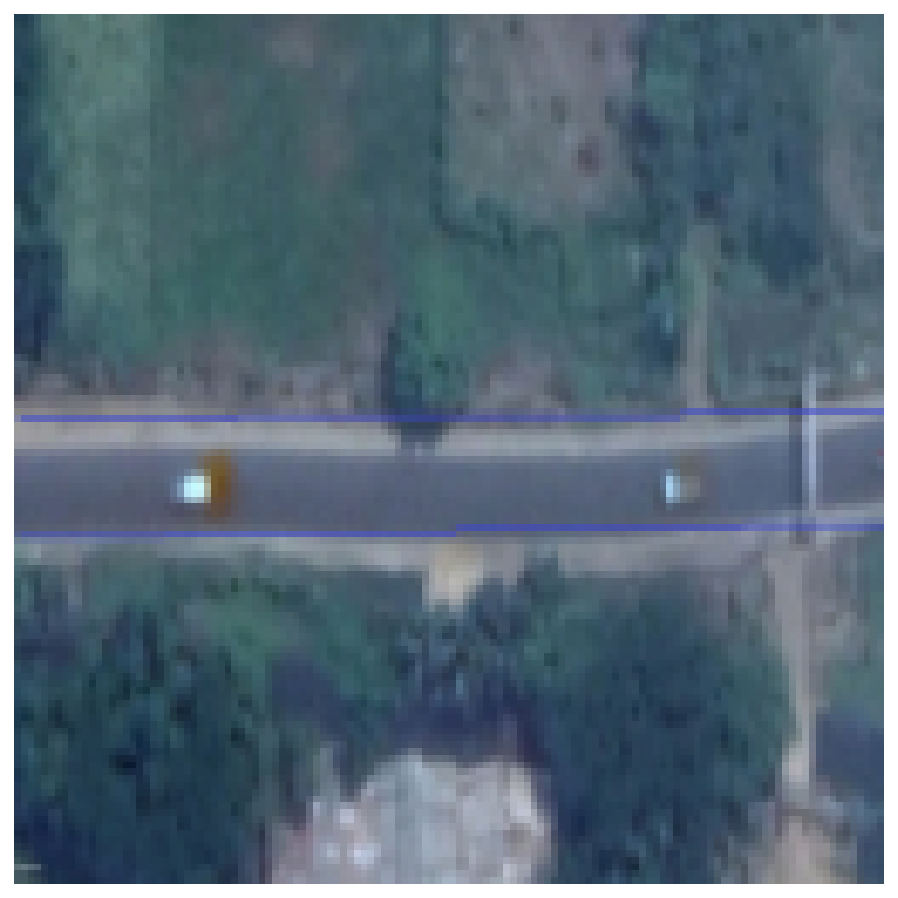

In [ ]:
img_path = glob(f'{test_folders[4]}/*png')[1]

show_image(img_path)

In [ ]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [ ]:
!rm -rf data

DATA_DIR = Path('test_data')

DATASETS = ['test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 251
fair: 290
good: 295
poor: 263
vbad: 231


In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=10, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 1330}

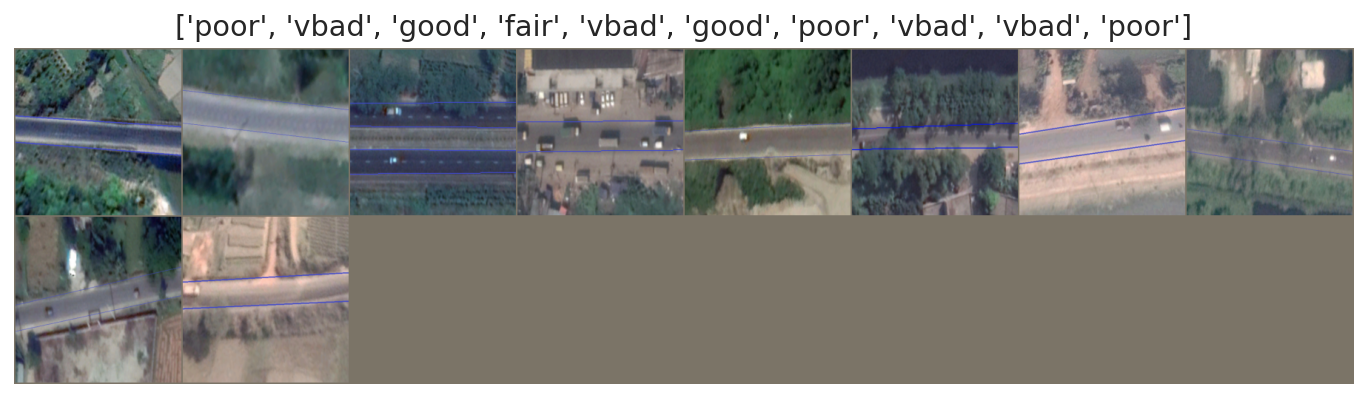

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20,10))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}\n'  f'true: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

In [ ]:
show_predictions(base_model, class_names, n_images=8)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [ ]:
#64*64
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.80      0.80      0.80       251
        fair       0.75      0.64      0.69       290
        good       0.70      0.83      0.76       295
        poor       0.84      0.79      0.82       263
        vbad       0.78      0.81      0.79       231

    accuracy                           0.77      1330
   macro avg       0.78      0.77      0.77      1330
weighted avg       0.77      0.77      0.77      1330



In [ ]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.87      0.85      0.86       251
        fair       0.86      0.74      0.80       290
        good       0.80      0.89      0.84       295
        poor       0.91      0.90      0.90       263
        vbad       0.82      0.86      0.84       231

    accuracy                           0.85      1330
   macro avg       0.85      0.85      0.85      1330
weighted avg       0.85      0.85      0.85      1330



In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

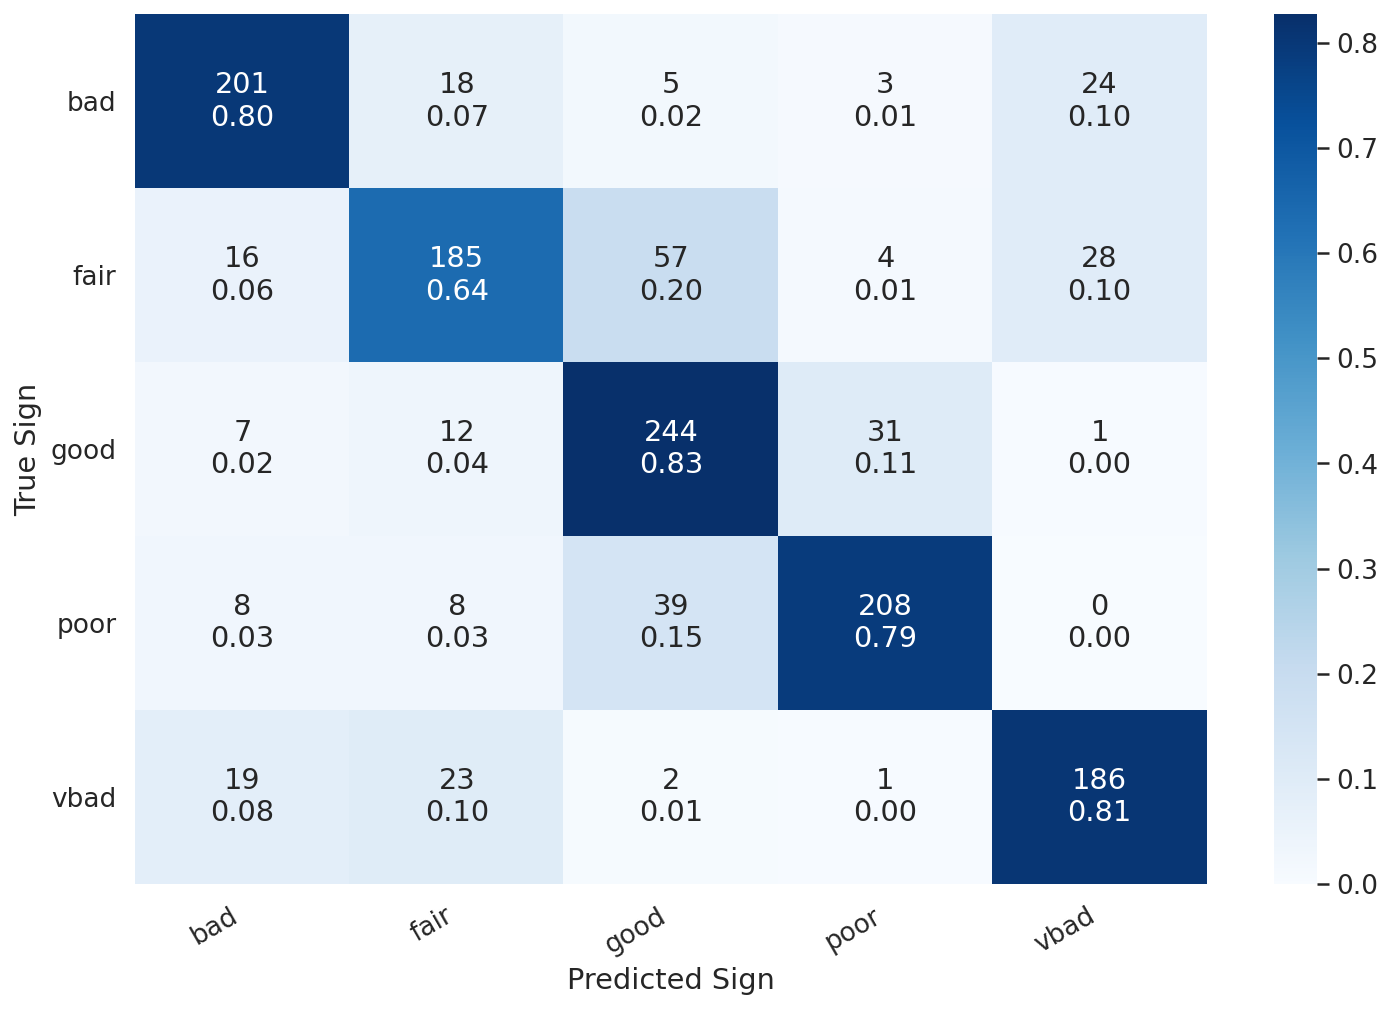

In [ ]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

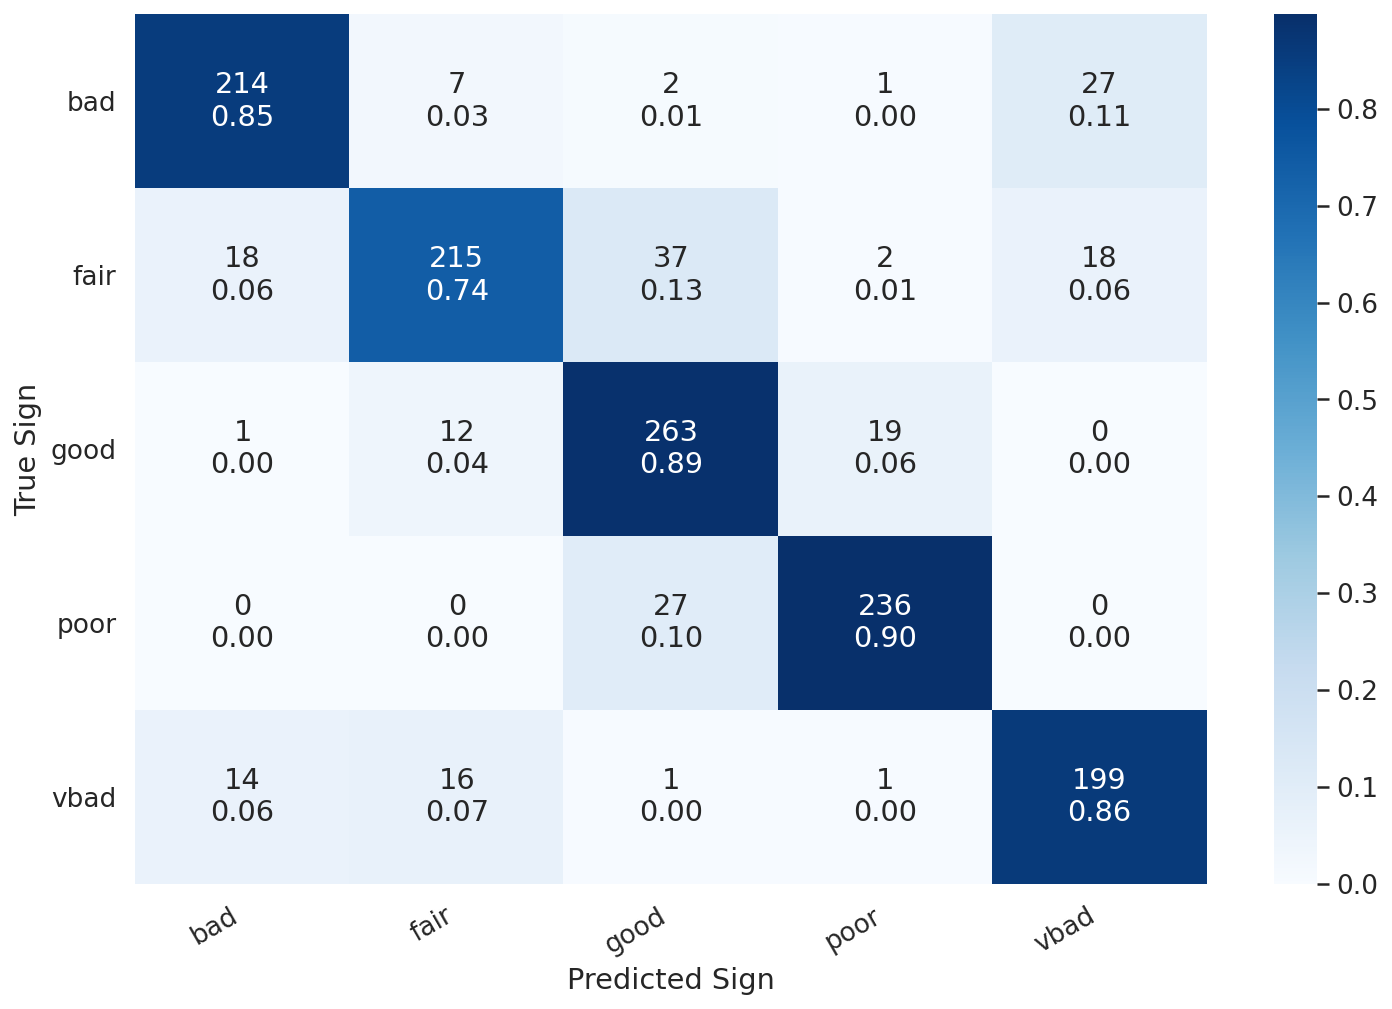

In [ ]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

# **Hold out dataset(New Road for testing)**

In [ ]:
held_folders = sorted(glob('/content/drive/MyDrive/heldoutV2/*'))
len(held_folders)

5

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

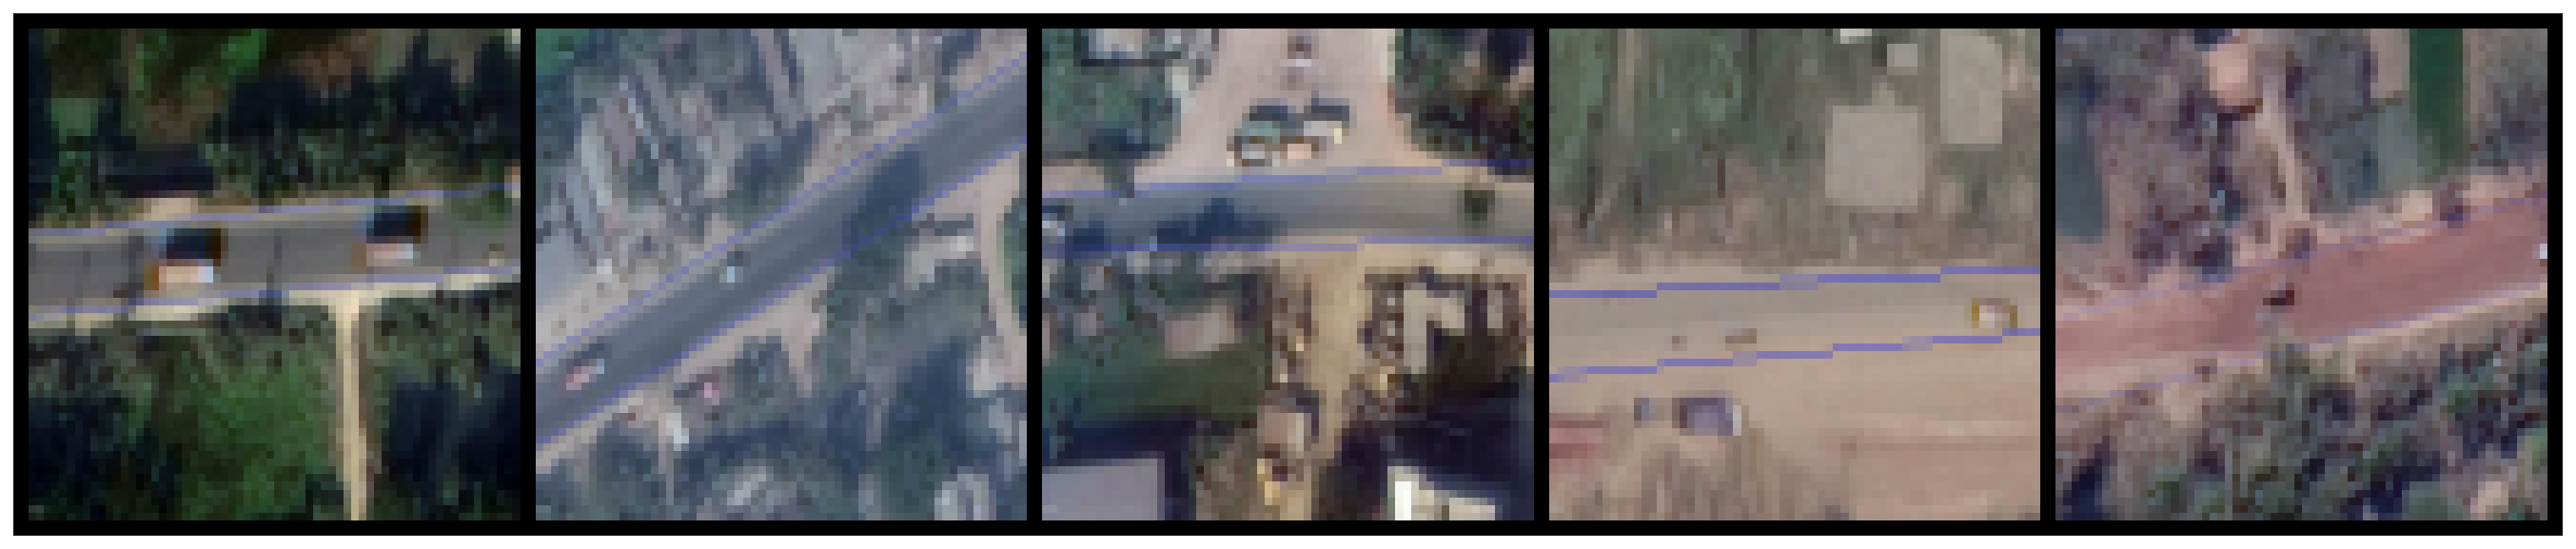

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in held_folders]
show_sign_grid(sample_images)

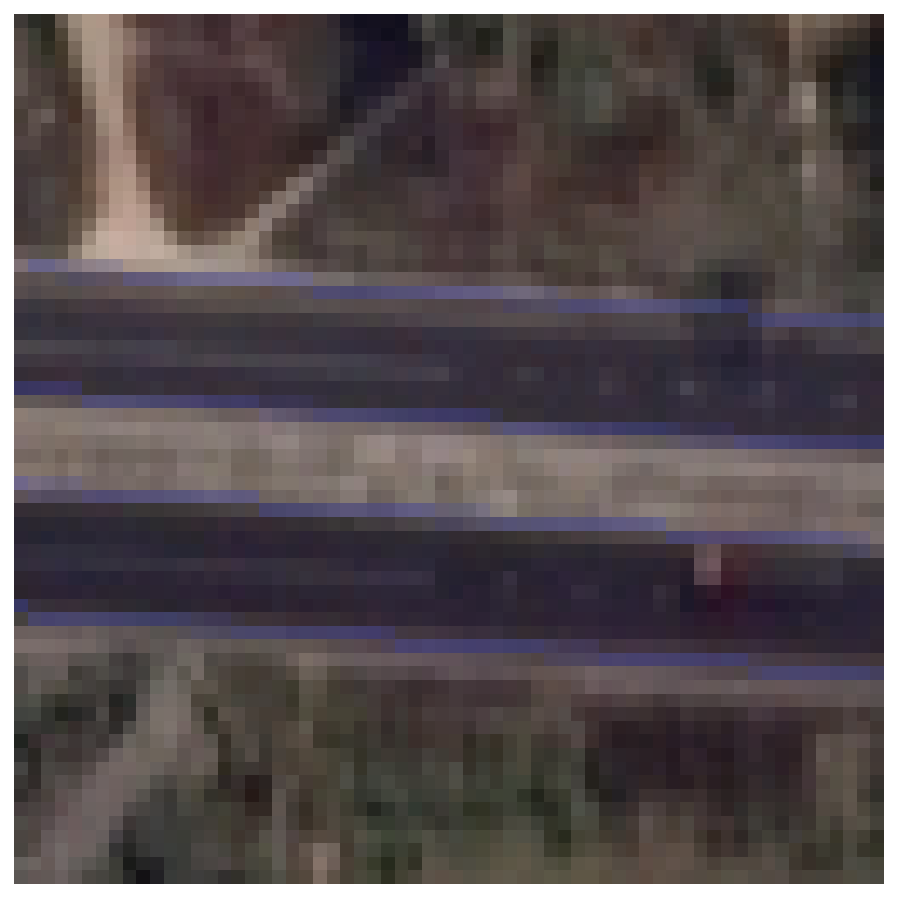

In [ ]:
img_path = glob(f'{held_folders[2]}/*png')[20]

show_image(img_path)

In [ ]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [ ]:
!rm -rf data

DATA_DIR = Path('heldoutx_data')

DATASETS = ['heldout_test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{held_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 104
fair: 115
good: 113
poor: 91
vbad: 94


In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'heldout_test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=10, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['heldout_test'].classes

dataset_sizes

{'heldout_test': 517}

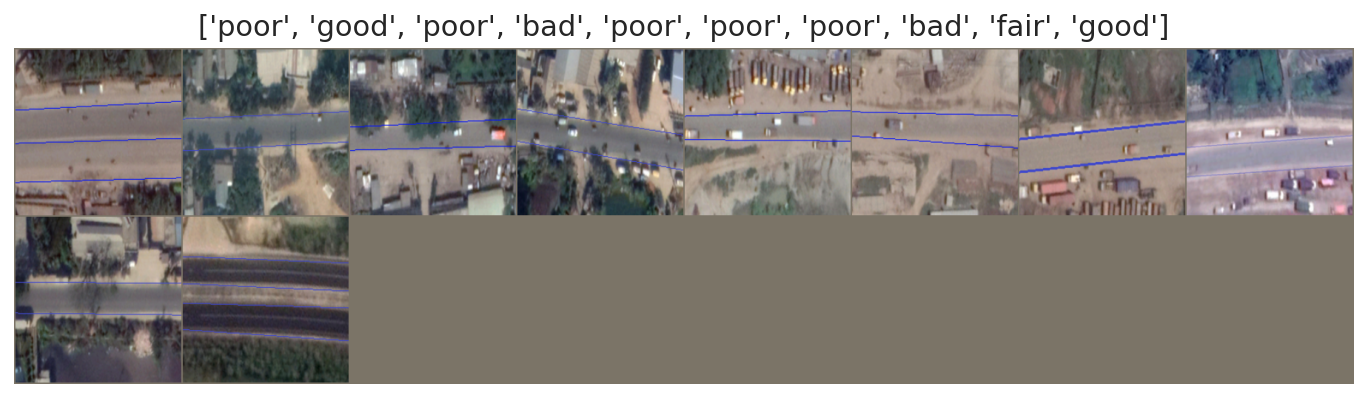

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['heldout_test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['heldout_test'])

In [ ]:
#64*64
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.66      0.74      0.70       104
        fair       0.36      0.53      0.43       115
        good       0.41      0.30      0.35       113
        poor       0.93      0.45      0.61        91
        vbad       0.69      0.77      0.73        94

    accuracy                           0.55       517
   macro avg       0.61      0.56      0.56       517
weighted avg       0.59      0.55      0.55       517



In [ ]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.48      0.75      0.59       104
        fair       0.39      0.47      0.43       115
        good       0.44      0.35      0.39       113
        poor       0.79      0.41      0.54        91
        vbad       0.67      0.59      0.63        94

    accuracy                           0.51       517
   macro avg       0.56      0.51      0.51       517
weighted avg       0.54      0.51      0.51       517



In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

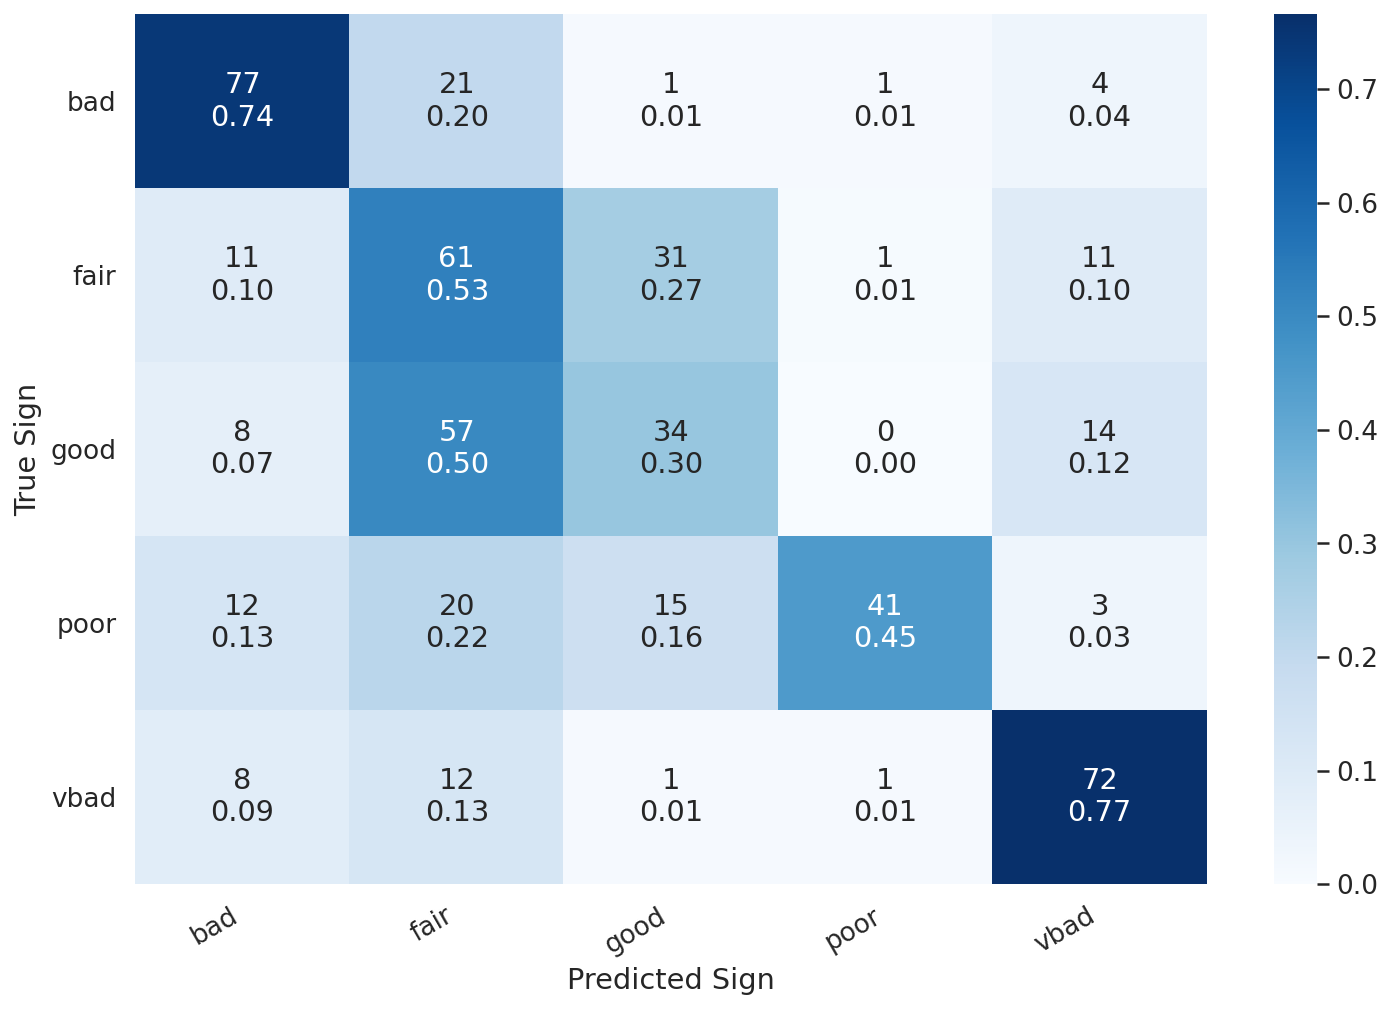

In [ ]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

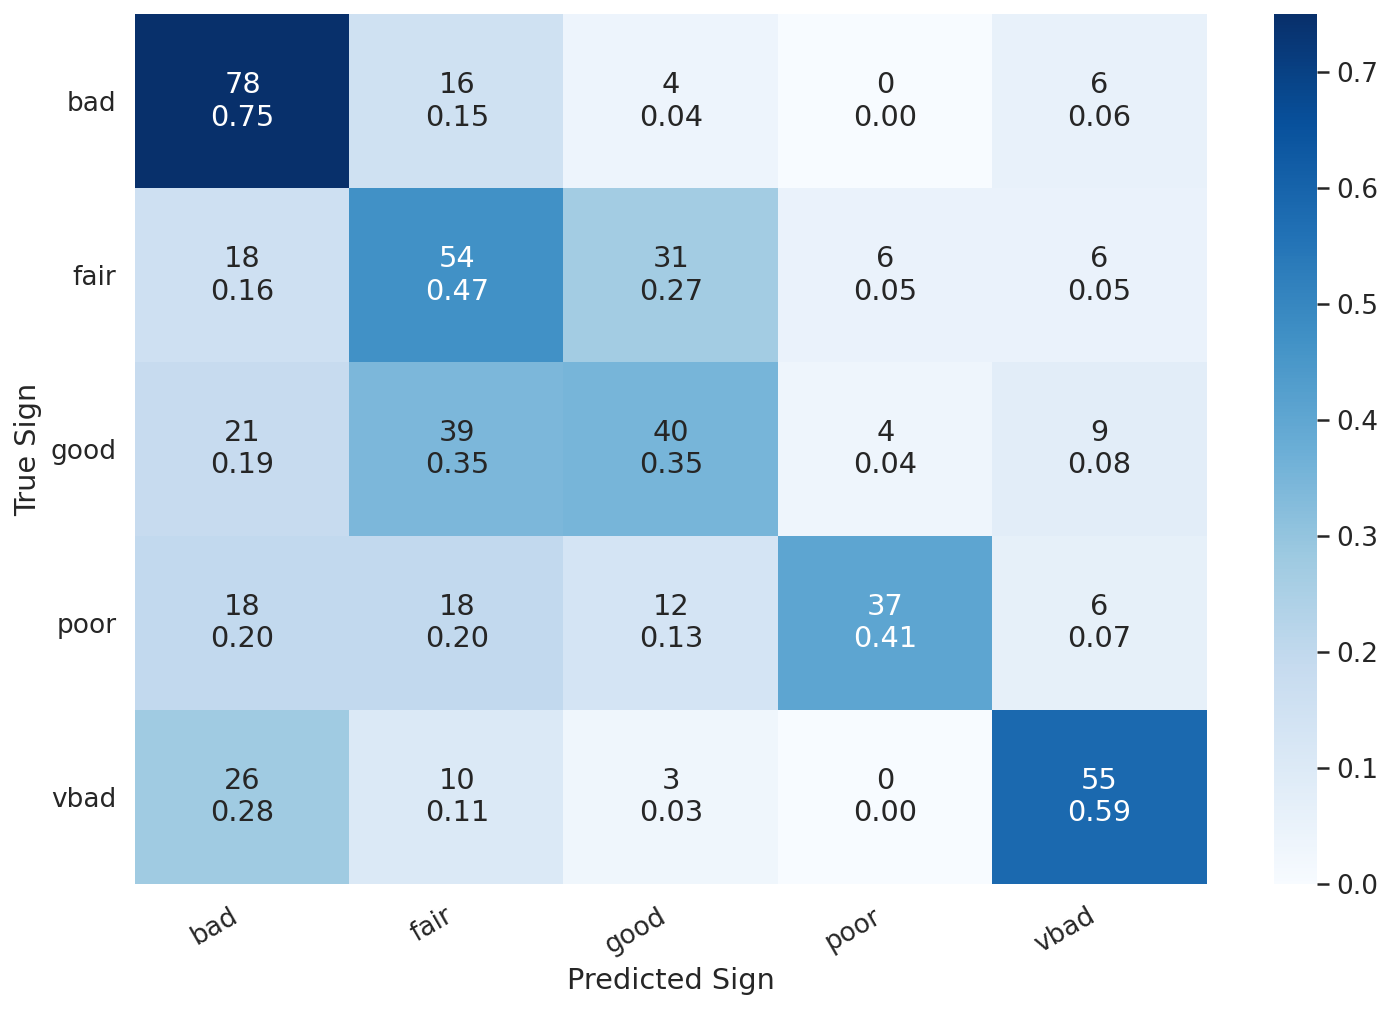

In [ ]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

In [ ]:
root_path = '/content/drive/My Drive/'

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(base_model.state_dict(), root_path + 'DenseNetmodel.pkl') 

In [ ]:
load_model = True

if load_model is True:
    base_model.load_state_dict(torch.load(root_path + 'DenseNetmodel.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

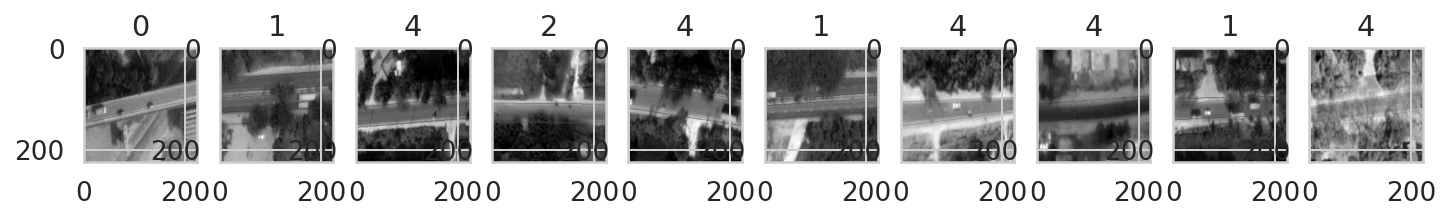

In [ ]:
for images, labels in data_loaders['heldout_test']:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    show_img = images[i][0].numpy().reshape(224, 224)
    ax[i].imshow(show_img,cmap='gray')
    ax[i].set_title(int(labels[i]))
    
plt.show()

In [ ]:
predictions = base_model.forward(images[:10].view(-1, 3,224,224).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [0 2 4 1 1 2 4 4 0 4]
